In [1]:
import os
import sys

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage import io

from data_generator import *
from model import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

sys.path.append("../")
from metrics import *


Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train/'
VAL_PATH = 'data/val/'

MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [3]:
image_generator = ImageDataGenerator(
    rotation_range=12,
    rescale=1./255,
    brightness_range=[.85, 1.0],
    shear_range=.1,
    zoom_range=.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    rotation_range=2,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

In [4]:
train_generator = generator(
    TRAIN_PATH,
    image_generator,
    label_generator,
    batch_sz=2,
)
val_generator = generator(
    VAL_PATH,
    image_generator,
    label_generator, 
    batch_sz=1
)

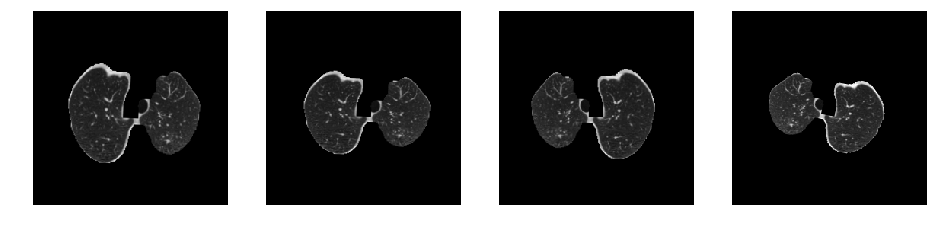

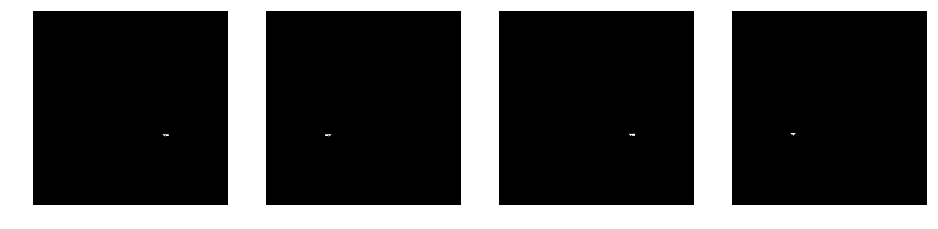

In [5]:
show_augmentation('data/train/image4/7.tif', image_generator, n_rows=1)
show_augmentation('data/train/label4/7.tif', label_generator, n_rows=1)

## Instantiate and Train the U-Net

In [6]:
model = unet3d_res()
model.compile(
    optimizer = Adam(lr=1e-4),
    loss=weighted_cross_entropy,
#     loss=dice_coef_weighted_loss,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.SpecificityAtSensitivity(.5),
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
targets is deprecated, use labels instead


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 8, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 256, 256, 8,  1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8,  256         conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, 8,  128         input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
model.fit_generator(
    train_generator,
    validation_data= val_generator,
    steps_per_epoch = 500,
    validation_steps=50,
    epochs = 20,
    callbacks=[model_checkpoint]
)

Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Found 1394 images belonging to 1 classes.
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
499/500 [============================>.] - ETA: 1s - loss: 0.0347 - acc: 0.9972 - precision: 0.0927 - recall: 0.1409 - specificity_at_sensitivity: 0.9791Found 50 images belonging to 1 classes.
Found 50 images belonging to 1

KeyboardInterrupt: 

In [ ]:
model.save('unet_lidc.hdf5') 

In [ ]:
model.load_weights('unet_lidc.hdf5')

## Test the U-Net

### Training set predictions

In [ ]:
# results = model.predict(X_test, 2, verbose=1)

idx = np.random.randint(len(os.listdir('data/train/image0')))
print(idx)

x0 = np.array(io.imread(f'data/train/image0/{idx}.tif', as_gray=True))/255
x1 = np.array(io.imread(f'data/train/image1/{idx}.tif', as_gray=True))/255
x2 = np.array(io.imread(f'data/train/image2/{idx}.tif', as_gray=True))/255
x3 = np.array(io.imread(f'data/train/image3/{idx}.tif', as_gray=True))/255
x4 = np.array(io.imread(f'data/train/image4/{idx}.tif', as_gray=True))/255
x5 = np.array(io.imread(f'data/train/image5/{idx}.tif', as_gray=True))/255
x6 = np.array(io.imread(f'data/train/image6/{idx}.tif', as_gray=True))/255
x7 = np.array(io.imread(f'data/train/image7/{idx}.tif', as_gray=True))/255

X = np.array([x0, x1, x2, x3, x4, x5, x6, x7])

y0 = np.array(io.imread(f'data/train/label0/{idx}.tif', as_gray=True))
y1 = np.array(io.imread(f'data/train/label1/{idx}.tif', as_gray=True))
y2 = np.array(io.imread(f'data/train/label2/{idx}.tif', as_gray=True))
y3 = np.array(io.imread(f'data/train/label3/{idx}.tif', as_gray=True))
y4 = np.array(io.imread(f'data/train/label4/{idx}.tif', as_gray=True))
y5 = np.array(io.imread(f'data/train/label5/{idx}.tif', as_gray=True))
y6 = np.array(io.imread(f'data/train/label6/{idx}.tif', as_gray=True))
y7 = np.array(io.imread(f'data/train/label7/{idx}.tif', as_gray=True))

Y = np.array([y0, y1, y2, y3, y4, y5, y6, y7])

Y_hat = model.predict(X.reshape(1, 256, 256, 8, 1))

#Plot
fig, axs = plt.subplots(8, 3, figsize=(12, 32))

for i in range(8):
    axs[i][0].imshow(X[i], cmap='bone')
    axs[i][1].imshow(Y[i], cmap='bone')
    axs[i][2].imshow(Y_hat.reshape(8, 256, 256)[i], cmap='bone')

plt.show()

### Test set predictions

In [ ]:
# results = model.predict(X_test, 2, verbose=1)

idx = np.random.randint(len(os.listdir('data/test/image0')))
print(idx)

x0 = np.array(io.imread(f'data/test/image0/{idx}.tif', as_gray=True))/255
x1 = np.array(io.imread(f'data/test/image1/{idx}.tif', as_gray=True))/255
x2 = np.array(io.imread(f'data/test/image2/{idx}.tif', as_gray=True))/255
x3 = np.array(io.imread(f'data/test/image3/{idx}.tif', as_gray=True))/255
x4 = np.array(io.imread(f'data/test/image4/{idx}.tif', as_gray=True))/255
x5 = np.array(io.imread(f'data/test/image5/{idx}.tif', as_gray=True))/255
x6 = np.array(io.imread(f'data/test/image6/{idx}.tif', as_gray=True))/255
x7 = np.array(io.imread(f'data/test/image7/{idx}.tif', as_gray=True))/255

X = np.array([x0, x1, x2, x3, x4, x5, x6, x7])

y0 = np.array(io.imread(f'data/test/label0/{idx}.tif', as_gray=True))
y1 = np.array(io.imread(f'data/test/label1/{idx}.tif', as_gray=True))
y2 = np.array(io.imread(f'data/test/label2/{idx}.tif', as_gray=True))
y3 = np.array(io.imread(f'data/test/label3/{idx}.tif', as_gray=True))
y4 = np.array(io.imread(f'data/test/label4/{idx}.tif', as_gray=True))
y5 = np.array(io.imread(f'data/test/label5/{idx}.tif', as_gray=True))
y6 = np.array(io.imread(f'data/test/label6/{idx}.tif', as_gray=True))
y7 = np.array(io.imread(f'data/test/label7/{idx}.tif', as_gray=True))

Y = np.array([y0, y1, y2, y3, y4, y5, y6, y7])

Y_hat = model.predict(X.reshape(1, 256, 256, 8, 1))

#Plot
fig, axs = plt.subplots(8, 3, figsize=(12, 32))

for i in range(8):
    axs[i][0].imshow(X[i], cmap='bone')
    axs[i][1].imshow(Y[i], cmap='bone')
    axs[i][2].imshow(Y_hat.reshape(8, 256, 256)[i], cmap='bone')

plt.show()